In [1]:
%load_ext autoreload

%autoreload 2

In [88]:
%matplotlib inline

from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.ndimage import distance_transform_edt

import emc2d

np.random.seed(2020)

## SImulated data

In [3]:
intensity = np.load("./data/4BED_t40_d5000.npy")

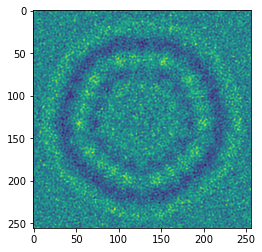

In [183]:
plt.imshow(intensity)

In [184]:
drift_radius = (20, 20)
mean_count= 0.05
motion_sigma = 1.
num_frames = 500
frame_size = (128, 128)
model_size = (frame_size[0] + 2*drift_radius[0], frame_size[1] + 2*drift_radius[1])
model = emc2d.sim.build_model(intensity, model_size=model_size, mean_count=mean_count)
n_drifts = (2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)

frames, traj = emc2d.sim.generate_frames(
    intensity, 
    frame_size, 
    drift_radius=drift_radius, 
    num_frames=num_frames, 
    mean_count=mean_count, 
    motion_sigma=motion_sigma)

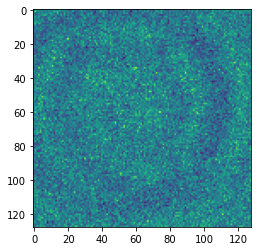

In [186]:
plt.imshow(frames[:].sum(0))

## Initialize EMC

In [254]:
emc = emc2d.core.EMC(
    frames=frames, 
    frame_size=(128, 128), 
    drift_radius=drift_radius, 
    init_model='random')

nnz / data_size = 4.82%, using dense data format
nnz / data_size = 4.82%, using dense data format
nnz / data_size = 4.82%, using dense data format


Text(0.5, 1.0, 'initial model')

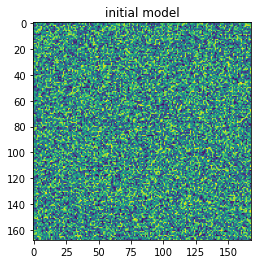

In [255]:
plt.imshow(emc.curr_model)
plt.title("initial model")

## Coarse graining the drift space

In [256]:
drift_in_use2 = emc2d.utils.drift_space_coarse_grain(drift_radius=drift_radius, multiple=(2, 2))
print(f"drifts {(2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)} reduced to  {len(drift_in_use2)}")

drifts 1681 reduced to  400


In [257]:
emc.run(iterations=10, drifts_in_use=drift_in_use2, lpfs=2.0)

100%|██████████| 10/10 [00:02<00:00,  4.49it/s]                                                                                                                            


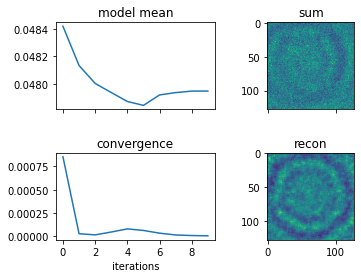

In [258]:
fig = emc2d.viz.show_emc_state(emc)

mse = 67.388


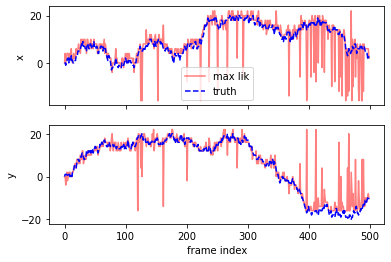

In [259]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [260]:
pmat = emc.folded_membership_probability

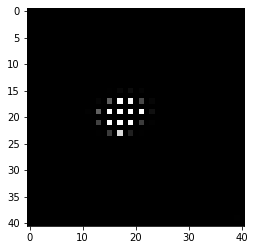

In [261]:
plt.imshow(pmat[1], vmin=0, vmax=0.01, cmap='gray')

## Select subregions for each frame

In [262]:
def select_frame_subregions(folded_membership_probability, 
                            drift_radius: Tuple[int, int], 
                            drifts_in_use: List[int], 
                            r: int, 
                            threshold: float = 1e-3):
    
    h, w = 2 * drift_radius[0] + 1, 2 * drift_radius[1] + 1
    n_frames = folded_membership_probability.shape[0]
    binary = folded_membership_probability < threshold
    bmap = np.array([distance_transform_edt(binary[k]) <= r for k in range(n_frames)])
    bmap_r = bmap.reshape(n_frames, -1)
    return [np.argwhere(b).squeeze() for b in bmap_r]

In [263]:
frame_drifts_in_use = select_frame_subregions(
    emc.folded_membership_probability, emc.drift_radius, emc.drifts_in_use, r=3, threshold=1e-2)

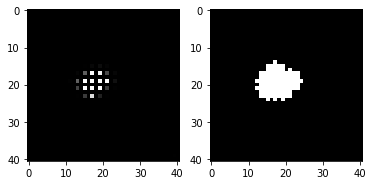

In [264]:
idx = 1
bmap = np.zeros(shape=(n_drifts))
bmap[frame_drifts_in_use[idx]] = 1

_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(pmat[idx], vmin=0, vmax=0.01, cmap='gray')
ax2.imshow(bmap.reshape((2*drift_radius[0] + 1), -1), cmap="gray");

(400, 500)

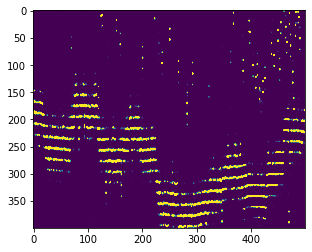

In [265]:
plt.imshow(emc.membership_probability, vmin=0, vmax=0.01)
emc.membership_probability.shape

In [271]:
emc.run_frame_sparse(iterations=10, frame_drifts_in_use=frame_drifts_in_use)

100%|██████████| 10/10 [01:31<00:00,  9.16s/it]                                                                                                                            


(1681, 500)

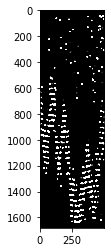

In [272]:
plt.imshow(emc.membership_probability, vmin=0, vmax=0.001, cmap='gray')
emc.membership_probability.shape

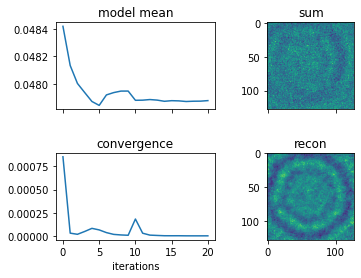

In [273]:
fig = emc2d.viz.show_emc_state(emc)

mse = 79.054


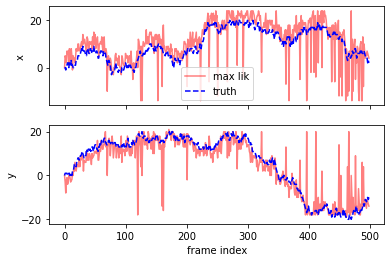

In [274]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [250]:
np.exp(-np.infty)

0.0

In [253]:
-np.infty < -1000

True